# Instructions

1. RUN THE CELL BELOW
2. Pick one of these strings: 
['PRECT',
 'PS',
 'PSL',
 'QREFHT',
 'T200',
 'T500',
 'TMQ',
 'TREFHT',
 'TS',
 'U850',
 'UBOT',
 'V850',
 'VBOT',
 'Z1000',
 'Z200',
 'ZBOT']
and call it variable
3. Pick a number between 0 and 7, call it time (preferably an even number)
4. Pick a month in 2 digit form as a string ie March is '03'
5. Pick a day in 2 digit form, ie the 28th is '28', the 1st is '01'
6. Call the function plot(month, day, time, variable)
7. Look at the cool plot
8. Note odd times don't have boxes

In [2]:
import netCDF4 as nc
from os import listdir, system
from os.path import isfile, join, isdir
import re
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 5,10

# this directory can be accessed from cori
maindir="/project/projectdirs/dasrepo/gordon_bell/climate/data/big_images/1979"
lsdir=listdir(maindir)

rpfile = re.compile(r"^cam5_.*\.nc$")
camfiles = [f for f in lsdir if rpfile.match(f)]

random_file = camfiles[22]

root = nc.Dataset(maindir+'/'+random_file, "r", format="NETCDF4")

prefix = 'cam5_1_amip_run2.cam2.h2.1979'
suffix = '00000.nc'

variables_of_interest =['PRECT',
 'PS',
 'PSL',
 'QREFHT',
 'T200',
 'T500',
 'TMQ',
 'TREFHT',
 'TS',
 'U850',
 'UBOT',
 'V850',
 'VBOT',
 'Z1000',
 'Z200',
 'ZBOT']

def get_boxes_for_given_time_slice(dataset, time_ind):
    '''given a dataset and a time index, returns a tuple for 
    each clinate event where each tuple is (xmin,xmax,ymin,ymax,category)'''
    mask = dataset['teca_mask'][:] == 1
    xmins, xmaxes, ymins, ymaxes, categories = [list(dataset[k][:,mask[0]][time_ind]) for k in [ u'teca_xmin',
                                                                                 u'teca_xmax',
                                                                                 u'teca_ymin',
                                                                                 u'teca_ymax',
                                                                                 u'teca_category']]
    if not all(xmins) and not all(xmaxes):
        print "No boxes for this time step!"
    return zip(xmins, xmaxes, ymins, ymaxes, categories)

from matplotlib import patches

def add_bbox(subplot,bbox):
    colors = ['r','g', 'b', 'y', 'k']
    xmin,xmax,ymin, ymax, category = bbox
    subplot.add_patch(patches.Rectangle(
    xy=(xmin,ymin),
    width=xmax - xmin,
    height=ymax - ymin,
    fill=False, color=colors[category]))

def plot_box(dataset, time_slice, variable):
    '''given a dataset, time slice and variable
    it will plot the 2D spatio-temporal-variable slice with the box'''
    im = dataset[variable][time_slice]
    boxes = get_boxes_for_given_time_slice(dataset, time_slice)
    f,sp = plt.subplots()
    sp.imshow(im)
    #for box in boxes:
    #    add_bbox(sp,box)
    plt.show()
    
def plot(month='05',day='05',time=0,variable='TMQ'):
    filename = '-'.join([prefix,month,day,suffix])
    print filename
    dataset = nc.Dataset(maindir+'/'+ filename, "r", format="NETCDF4")
    plot_box(dataset, time, variable)
    
def get_img(month='05', day='05', time=0, variable='TMQ'):
    filename = '-'.join([prefix,month,day,suffix])
    #print filename
    dataset = nc.Dataset(maindir+'/'+ filename, "r", format="NETCDF4")
    return dataset[variable][time]

def get_img_full(month='05', day='05', time=0):
    return np.asarray(
        [ get_img(month, day, time, variable=v) for v in variables_of_interest ],
        dtype="float32"
    )
    

NameError: name 'month' is not defined

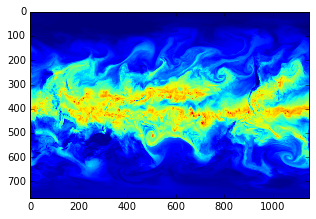

In [2]:
plt.imshow( get_img(month='10', day='31', time=0, variable='TMQ') )

Ok, we need each image to be a 3d tensor where the first axis is each variable like TMQ, etc.

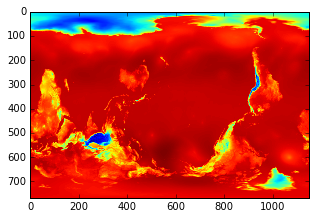

In [3]:
plt.imshow( get_img_full(month='10', day='31', time=0)[1] )

Slicing function

In [3]:
def get_slices(img, img_size=128, step_size=20):
    slices = []
    _, height, width = img.shape
    for y in range(0, height, step_size):
        for x in range(0, width, step_size):
            chunk = img[:, y:y+img_size, x:x+img_size]
            if chunk.shape[1::] == (img_size,img_size):
                slices.append(chunk)
    return slices

In [4]:
months = ["%02d" % (i,) for i in range(1,12+1) ]
days = ["%02d" % (i,) for i in range(1,31+1) ]
print months
print days

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


In [5]:
import cPickle as pickle
from multiprocessing import Pool


In [6]:
def _parallel_get_slices(month,day,t):
    arr = get_slices( get_img_full(month=month, day=day, time=t) )
    arr = np.asarray(arr, dtype="float32")
    print month, day, t
    #with open("../../climate_data/%s_%s_%i.pkl" % (month,day,t), "wb") as f:
    #    pickle.dump(arr, f, pickle.HIGHEST_PROTOCOL)
    np.save("../../climate_data/%s_%s_%i.npy" % (month,day,t), arr)
def parallel_get_slices(args):
    return _parallel_get_slices(*args)

In [7]:
cfgs = []
for month in months:
    for day in days:
        for t in range(0,7+1):
            cfgs.append( (month,day,t) )
print len(cfgs)
print cfgs[0:10]

2976
[('01', '01', 0), ('01', '01', 1), ('01', '01', 2), ('01', '01', 3), ('01', '01', 4), ('01', '01', 5), ('01', '01', 6), ('01', '01', 7), ('01', '02', 0), ('01', '02', 1)]


In [9]:
for t in cfgs[0:50]:
    _parallel_get_slices(t)

('01', '01', 0)
('01', '01', 1)
('01', '01', 2)
('01', '01', 3)
('01', '01', 4)
('01', '01', 5)
('01', '01', 6)
('01', '01', 7)
('01', '02', 0)
('01', '02', 1)


In [1]:
mask = dataset['teca_mask'][:] == 1

NameError: name 'dataset' is not defined